Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

Load Data

In [2]:
# Load data
data = pd.read_csv('/home/shubham/2021_6sense_DS_Takehome_Challenge/training.tsv', delimiter='\t', header=None, names=['user_id', 'date', 'activity'])
data_test = pd.read_csv('/home/shubham/2021_6sense_DS_Takehome_Challenge/test.tsv', delimiter='\t', header=None, names=['user_id', 'date', 'activity'])

EDA

In [3]:
data.head()

,user_id,date,activity
0,00002acbe042d69,2013-07-11,EmailOpen
1,00002acbe042d69,2013-07-11,FormSubmit
2,00002acbe042d69,2013-07-15,EmailOpen
3,00002acbe042d69,2013-07-17,EmailOpen
4,00002acbe042d69,2013-07-18,EmailOpen


In [4]:
data.shape

(4918677, 3)

<Axes: title={'center': 'Frequency of various activities in the Training Data'}, xlabel='activity'>

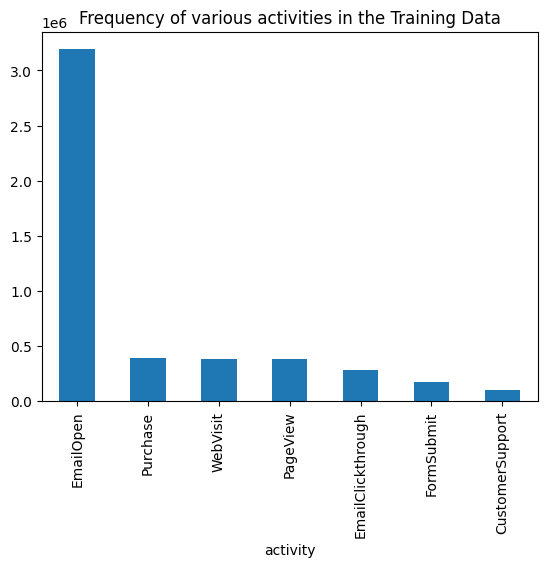

In [5]:
data['activity'].value_counts().plot(kind='bar', title='Frequency of various activities in the Training Data')

In [6]:
# Convert date column to datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data_test['date'] = pd.to_datetime(data_test['date'], errors='coerce')

# Convert activity column to lowercase
data['activity'] = data['activity'].str.lower()
data_test['activity'] = data_test['activity'].str.lower()

Feature Extraction

In [7]:
# Extract temporal features
data['day_of_week'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month
data['day_of_month'] = data['date'].dt.day

data_test['day_of_week'] = data_test['date'].dt.dayofweek
data_test['month'] = data_test['date'].dt.month
data_test['day_of_month'] = data_test['date'].dt.day

# Calculate time since last activity
data['time_since_last_activity'] = data.groupby('user_id')['date'].diff().dt.days.fillna(0)
data_test['time_since_last_activity'] = data_test.groupby('user_id')['date'].diff().dt.days.fillna(0)
data['time_since_last_activity'] = data['time_since_last_activity'].astype(int)
data_test['time_since_last_activity'] = data_test['time_since_last_activity'].astype(int)

# Create target variable: Purchase indicator
data['purchase'] = np.where(data['activity'] == 'purchase', 1, 0)

# Encode activities
label_encoder = LabelEncoder()
data['activity_encoded'] = label_encoder.fit_transform(data['activity'])
data_test['activity_encoded'] = label_encoder.transform(data_test['activity'])


# Aggregate data by user_id for Train Data
user_agg = data.groupby('user_id').agg({
    'activity_encoded': lambda x: list(x),
    'day_of_week': lambda x: list(x),
    'month': lambda x: list(x),
    'day_of_month': lambda x: list(x),
    'time_since_last_activity': lambda x: list(x),
    'purchase': 'sum'
}).reset_index()

# Aggregate data by user_id for Test Data
user_agg_test = data_test.groupby('user_id').agg({
    'activity_encoded': lambda x: list(x),
    'day_of_week': lambda x: list(x),
    'month': lambda x: list(x),
    'day_of_month': lambda x: list(x),
    'time_since_last_activity': lambda x: list(x)
}).reset_index()

# Label Column
user_agg['purchase_target'] = user_agg['purchase'].apply(lambda x: 1 if x > 0 else 0)

# Calculate the sequence lengths
seq_lengths = user_agg['activity_encoded'].apply(len)
seq_length = int(np.percentile(seq_lengths, 95))
# seq_length = max(seq_lengths)

print(f"sequence length (95 Percentile): {seq_length}")

# Define sequence length and pad sequences
def pad_sequences(sequences, maxlen):
    padded = np.zeros((len(sequences), maxlen))
    for i, seq in enumerate(sequences):
        if len(seq) > maxlen:
            padded[i] = np.array(seq[:maxlen])
        else:
            padded[i, -len(seq):] = np.array(seq)
    return padded

# Standardisation

features = ['activity_encoded', 'time_since_last_activity', 'day_of_week', 'month', 'day_of_month']
scalers = {feature: StandardScaler() for feature in features}

all_features_train = []
all_features_test = []
for feature in features:
    scaled_train = scalers[feature].fit_transform(pad_sequences(user_agg[feature], seq_length).reshape(-1, 1)).reshape(len(user_agg), seq_length)
    scaled_test = scalers[feature].transform(pad_sequences(user_agg_test[feature], seq_length).reshape(-1, 1)).reshape(len(user_agg_test), seq_length)
    all_features_train.append(scaled_train)
    all_features_test.append(scaled_test)



sequence length (95 Percentile): 52


Down Sampling Majority Class

In [8]:
# # Separate the indices for class 0 and class 1
# class_0_indices = np.where(user_agg['purchase_target'] == 0)[0]
# class_1_indices = np.where(user_agg['purchase_target'] == 1)[0]

# # Randomly undersample class 0 indices to match the number of class 1 indices
# undersampled_class_0_indices = np.random.choice(class_0_indices, size=len(class_1_indices), replace=False)

# # Combine the undersampled class 0 indices with class 1 indices
# balanced_indices = np.concatenate([undersampled_class_0_indices, class_1_indices])

# # Create balanced dataset
# user_agg = user_agg.iloc[balanced_indices].reset_index(drop=True)


Activities performed while purchasing vs not purchasing

/tmp/ipykernel_3375236/3589809208.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(activity_names, rotation=45, ha='right')
/tmp/ipykernel_3375236/3589809208.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(activity_names, rotation=45, ha='right')


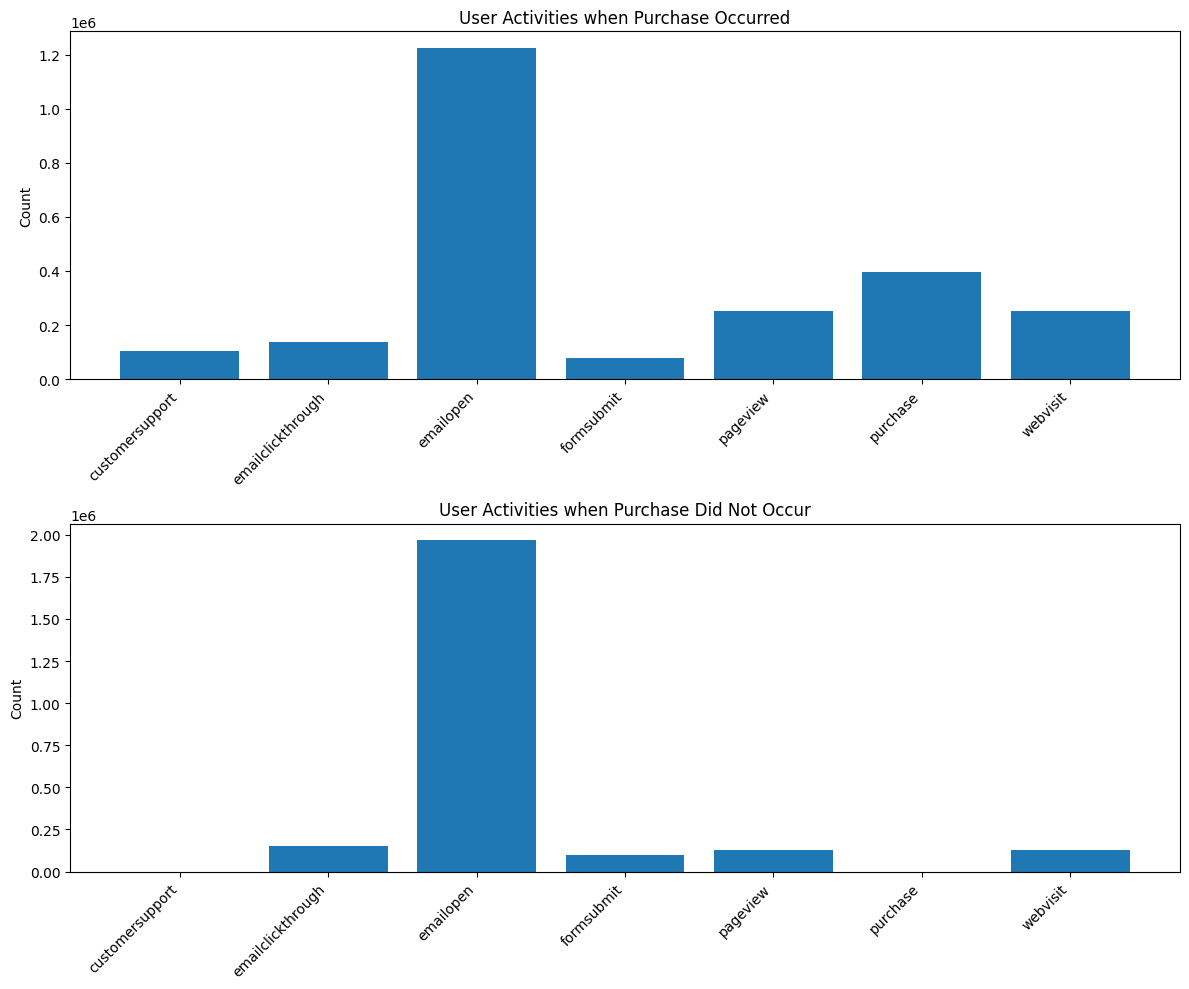

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten activities for users who made a purchase and those who didn't
purchased_activities = []
not_purchased_activities = []

for _, row in user_agg.iterrows():
    if row['purchase'] > 0:
        purchased_activities.extend(row['activity_encoded'])
    else:
        not_purchased_activities.extend(row['activity_encoded'])

# Convert lists to numpy arrays for easy counting
purchased_activities = np.array(purchased_activities)
not_purchased_activities = np.array(not_purchased_activities)

# Get the names of activities based on the label encoding
activity_names = label_encoder.inverse_transform(np.arange(len(label_encoder.classes_)))

# Count occurrences of each activity
purchased_counts = np.bincount(purchased_activities, minlength=len(activity_names))
not_purchased_counts = np.bincount(not_purchased_activities, minlength=len(activity_names))

# Plot histograms
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

ax[0].bar(activity_names, purchased_counts)
ax[0].set_title('User Activities when Purchase Occurred')
ax[0].set_ylabel('Count')
ax[0].set_xticklabels(activity_names, rotation=45, ha='right')

ax[1].bar(activity_names, not_purchased_counts)
ax[1].set_title('User Activities when Purchase Did Not Occur')
ax[1].set_ylabel('Count')
ax[1].set_xticklabels(activity_names, rotation=45, ha='right')

plt.tight_layout()
plt.show()


Did purchase happen more on certain Days, Dates and Months?

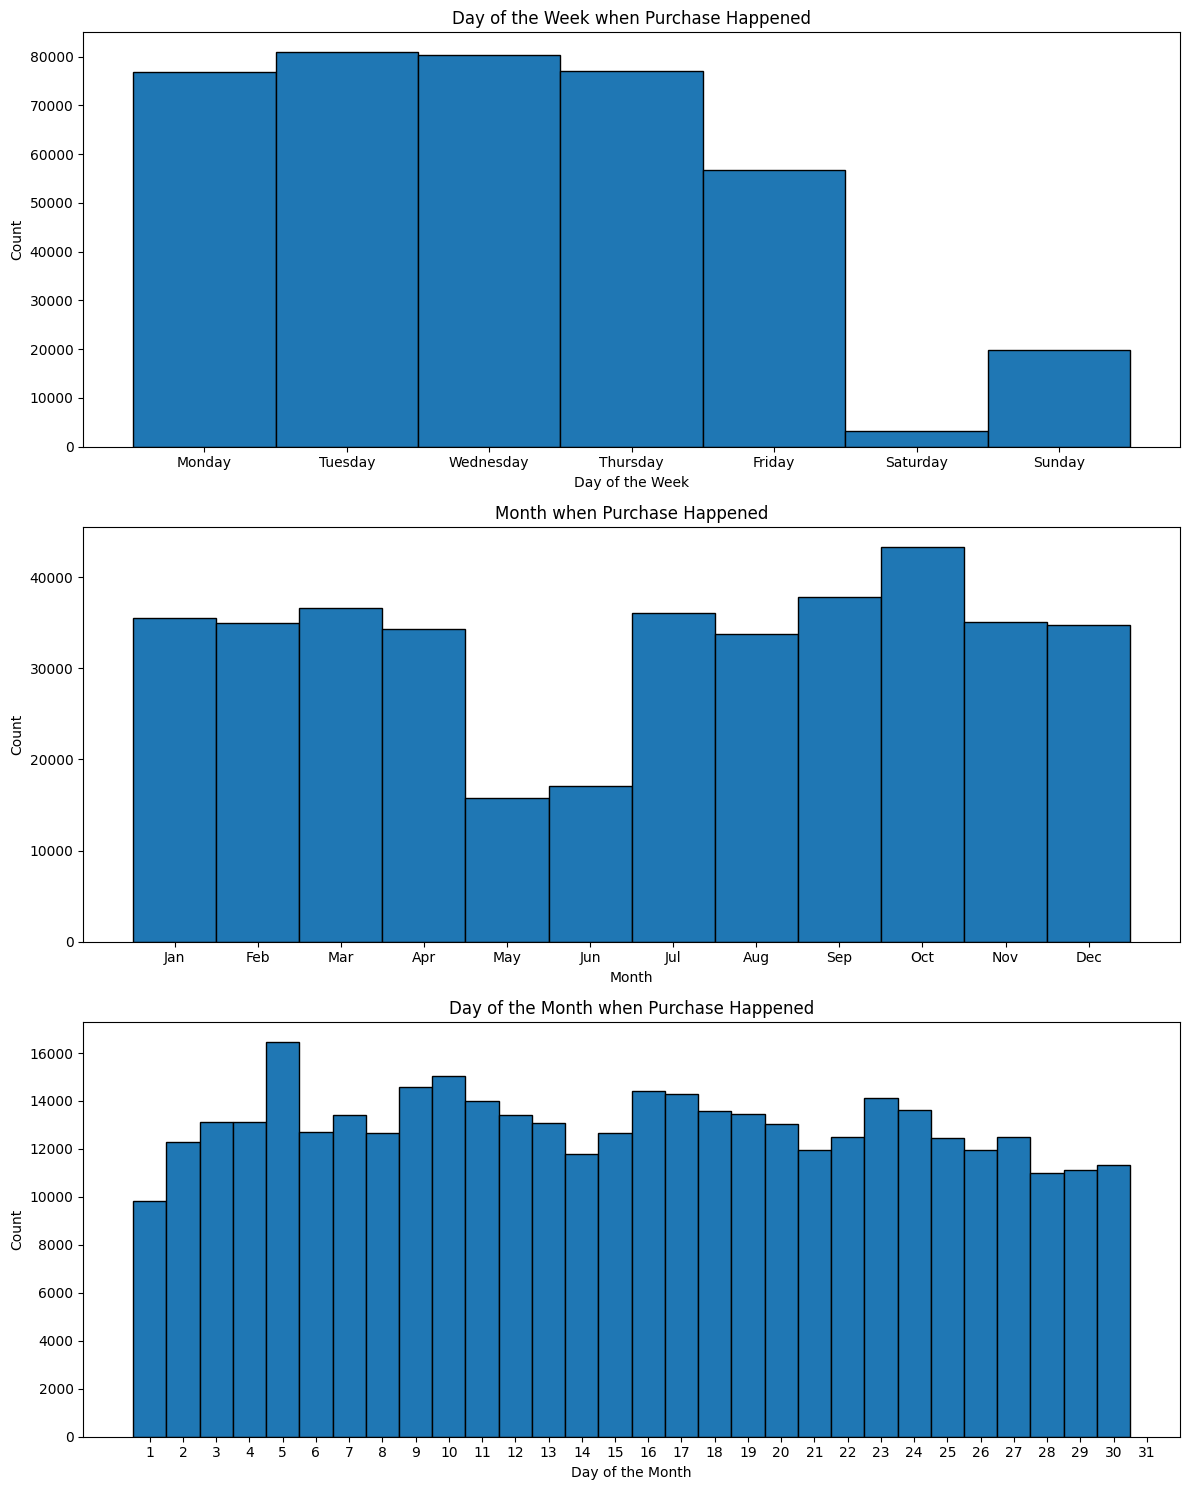

In [10]:
# Extract 'day_of_week', 'month', and 'day_of_month' for users who made a purchase
days_of_week_purchase = []
months_purchase = []
days_of_month_purchase = []

for _, row in data.iterrows():
    if row['activity'] == 'purchase':
        days_of_week_purchase.append(row['day_of_week'])
        months_purchase.append(row['month'])
        days_of_month_purchase.append(row['day_of_month'])

# Convert lists to numpy arrays for easy plotting
days_of_week_purchase = np.array(days_of_week_purchase)
months_purchase = np.array(months_purchase)
days_of_month_purchase = np.array(days_of_month_purchase)

# Plot histograms
fig, ax = plt.subplots(3, 1, figsize=(12, 15))

# Day of the Week
ax[0].hist(days_of_week_purchase, bins=np.arange(0, 8)-0.5, edgecolor='black')
ax[0].set_title('Day of the Week when Purchase Happened')
ax[0].set_xlabel('Day of the Week')
ax[0].set_ylabel('Count')
ax[0].set_xticks(np.arange(7))
ax[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Month
ax[1].hist(months_purchase, bins=np.arange(1, 14)-0.5, edgecolor='black')
ax[1].set_title('Month when Purchase Happened')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Count')
ax[1].set_xticks(np.arange(1, 13))
ax[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Day of the Month
ax[2].hist(days_of_month_purchase, bins=np.arange(1, 32)-0.5, edgecolor='black')
ax[2].set_title('Day of the Month when Purchase Happened')
ax[2].set_xlabel('Day of the Month')
ax[2].set_ylabel('Count')
ax[2].set_xticks(np.arange(1, 32))

plt.tight_layout()
plt.show()


Final Data Preperation

In [11]:
X = np.stack(all_features_train, axis=-1)
X_test = np.stack(all_features_test, axis=-1)

y = user_agg['purchase_target'].values

# Reshape X to 3D for LSTM: (num_samples, seq_length, input_size)
X = X.reshape((X.shape[0], seq_length, X.shape[2]))
X_test = X_test.reshape((X_test.shape[0], seq_length, X_test.shape[2]))


Stratified Train / Validation Split due to Imbalanced Data

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

# Initialize StratifiedShuffleSplit
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_index, val_index in strat_split.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

# Calculate class weights
class_counts = np.bincount(y_train)
class_weights = 1. / class_counts
positive_class_weights = class_weights[1] / class_weights[0]
positive_class_weights = torch.tensor(positive_class_weights, dtype=torch.float32)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Update input size
input_size = X.shape[2]  # Updated input size based on concatenated features


Feature Correlation with Target Variable

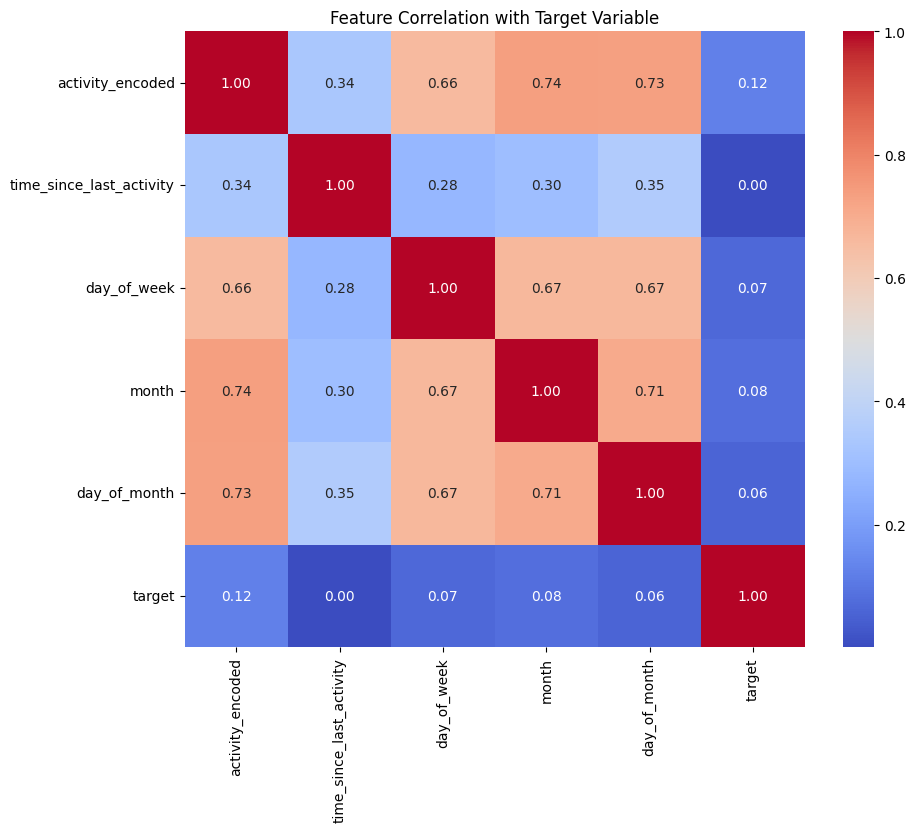

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten the 3D matrix into 2D for correlation computation
num_samples, seq_length, num_features = X.shape
X_flat = X.reshape(num_samples * seq_length, num_features)

# Repeat the target variable for each time step to match the flattened feature matrix
y_flat = np.repeat(y, seq_length)

# Create a DataFrame for easier manipulation
feature_names = ['activity_encoded', 'time_since_last_activity', 'day_of_week', 'month', 'day_of_month']
df_features = pd.DataFrame(X_flat, columns=feature_names)
df_features['target'] = y_flat

# Compute the correlation matrix
correlation_matrix = df_features.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation with Target Variable')
plt.show()

Correlation of User Activities with Purchase Target

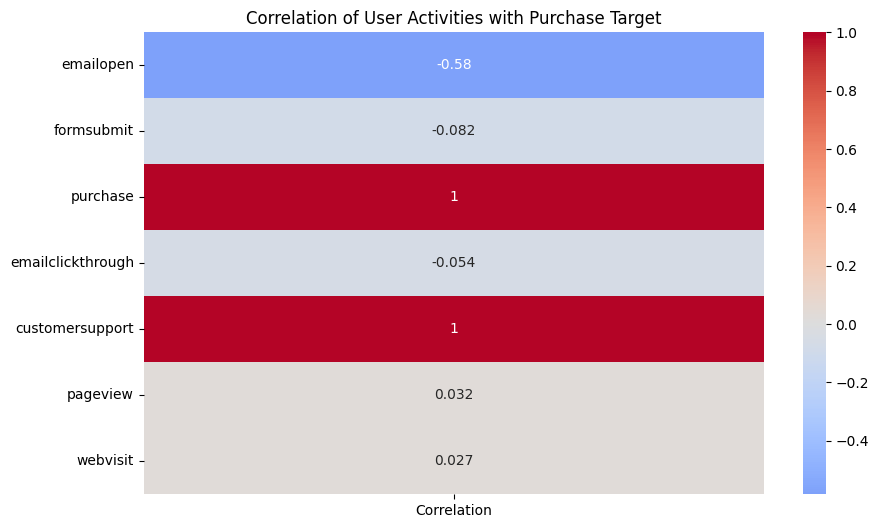

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract unique activities and their encoded values
unique_activities = data['activity'].unique()
activity_mapping = {activity: label_encoder.transform([activity])[0] for activity in unique_activities}

# Calculate correlation between each activity and the target variable
activity_corr = {}
for activity, encoded_value in activity_mapping.items():
    user_agg[activity] = user_agg['activity_encoded'].apply(lambda x: 1 if encoded_value in x else 0)
    activity_corr[activity] = user_agg[[activity, 'purchase_target']].corr().iloc[0, 1]

# Convert correlation dictionary to DataFrame
activity_corr_df = pd.DataFrame.from_dict(activity_corr, orient='index', columns=['Correlation'])

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(activity_corr_df, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of User Activities with Purchase Target')
plt.show()

Model Definition

In [15]:
# Define LSTM model with the updated input size
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

# Hyperparameters
hidden_size = 64
num_layers = 2
output_size = 1
num_epochs = 50
learning_rate = 0.00005



Training

In [16]:
# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Reinitialize model with the new input size
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.BCEWithLogitsLoss(pos_weight=positive_class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.to(device)




# Early stopping parameters
patience = 3
min_delta = 0.001
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total_val += y_batch.size(0)
            correct_val += (predicted == y_batch).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Early stopping check
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs')
        break


/home/shubham/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/50, Train Loss: 0.8278, Train Accuracy: 0.8545, Val Loss: 0.7701, Val Accuracy: 0.9138
Epoch 2/50, Train Loss: 0.7631, Train Accuracy: 0.9167, Val Loss: 0.7553, Val Accuracy: 0.9258
Epoch 3/50, Train Loss: 0.7547, Train Accuracy: 0.9243, Val Loss: 0.7489, Val Accuracy: 0.9322
Epoch 4/50, Train Loss: 0.7505, Train Accuracy: 0.9294, Val Loss: 0.7510, Val Accuracy: 0.9321
Epoch 5/50, Train Loss: 0.7540, Train Accuracy: 0.9226, Val Loss: 0.7457, Val Accuracy: 0.9365
Epoch 6/50, Train Loss: 0.7477, Train Accuracy: 0.9329, Val Loss: 0.7452, Val Accuracy: 0.9367
Epoch 7/50, Train Loss: 0.7489, Train Accuracy: 0.9324, Val Loss: 0.7475, Val Accuracy: 0.9361
Epoch 8/50, Train Loss: 0.7450, Train Accuracy: 0.9374, Val Loss: 0.7411, Val Accuracy: 0.9467
Epoch 9/50, Train Loss: 0.7383, Train Accuracy: 0.9484, Val Loss: 0.7338, Val Accuracy: 0.9560
Epoch 10/50, Train Loss: 0.7347, Train Accuracy: 0.9531, Val Loss: 0.7286, Val Accuracy: 0.9643
Epoch 11/50, Train Loss: 0.7302, Train Accuracy: 

Prediction

In [17]:
# Predict on test data
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_pred = model(X_test_tensor)
    y_test_pred = (y_test_pred.cpu().numpy() > 0.5).astype(int)

# Save predictions to CSV file
user_agg_test['purchase_prediction'] = y_test_pred
user_agg_test[['user_id', 'purchase_prediction']].to_csv('/home/shubham/2021_6sense_DS_Takehome_Challenge/test_predictions_LSTM.csv', index=False)
torch.save(model.state_dict(), '/home/shubham/2021_6sense_DS_Takehome_Challenge/lstm')

In [18]:
# model = torch.load('/home/shubham/2021_6sense_DS_Takehome_Challenge/lstm')